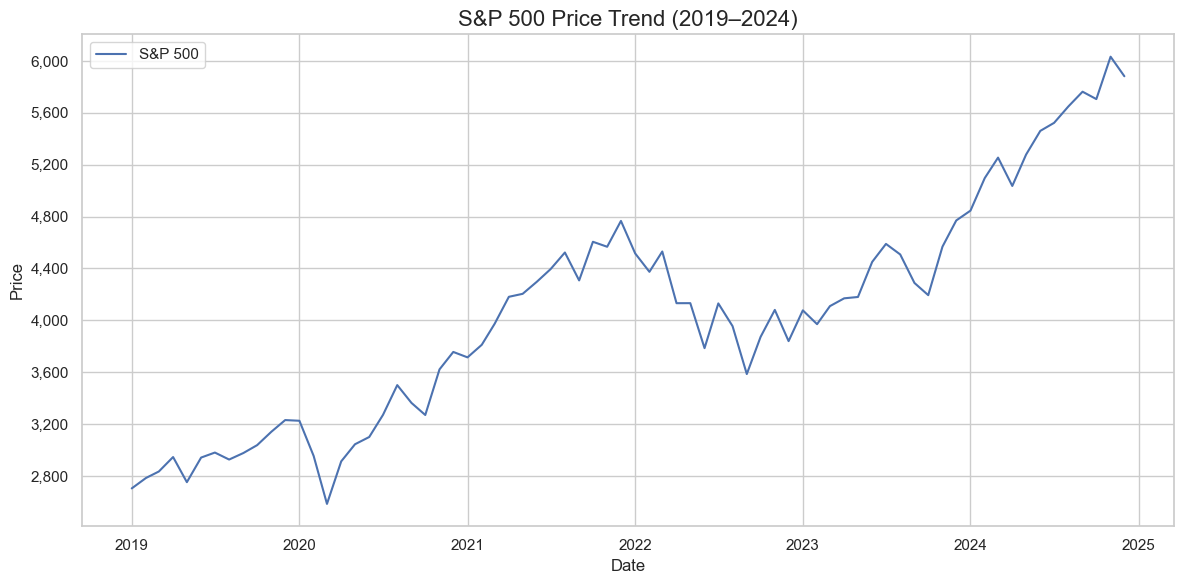

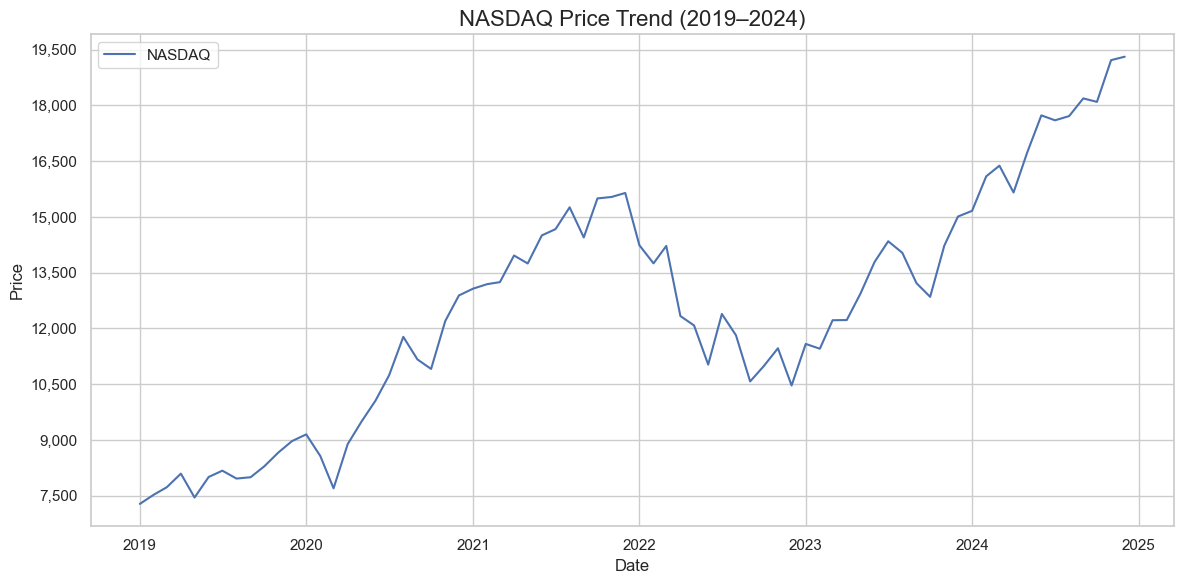

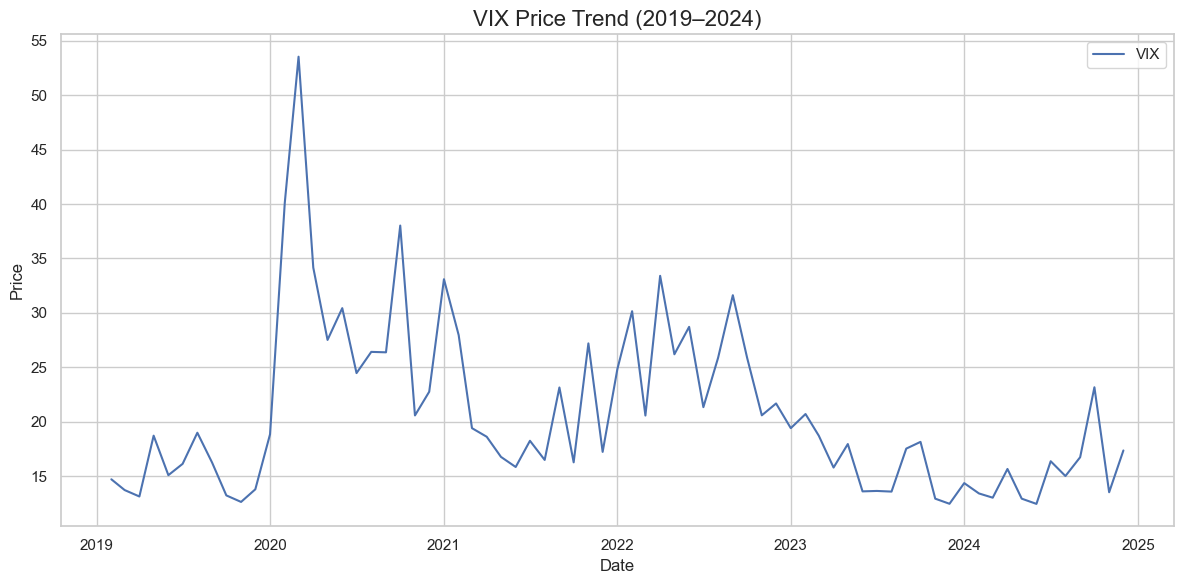

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

# 设置风格
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# 文件路径
file_paths = {
    'S&P 500': 'data/SP500.csv',
    'NASDAQ': 'data/NASDAQ.csv',
    'VIX': 'data/VIX.csv'
}

# 遍历绘图
for name, path in file_paths.items():
    df = pd.read_csv(path)

    # 预处理
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date')

    # 保证 Price 是数值类型（清除 $, , 等可能字符）
    df['Price'] = pd.to_numeric(df['Price'].astype(str).str.replace('[\$,]', '', regex=True), errors='coerce')

    # 绘图
    plt.figure()
    ax = sns.lineplot(x='Date', y='Price', data=df, label=name)

    # Y轴设置：减少刻度密度
    ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=10))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

    plt.title(f"{name} Price Trend (2019–2024)", fontsize=16)
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.tight_layout()
    plt.show()


# stage 1



🔍 开始分析: S&P 500
✅ 完成: S&P 500（最优段数: 5, AIC: 715.78, 用时: 1.01秒）


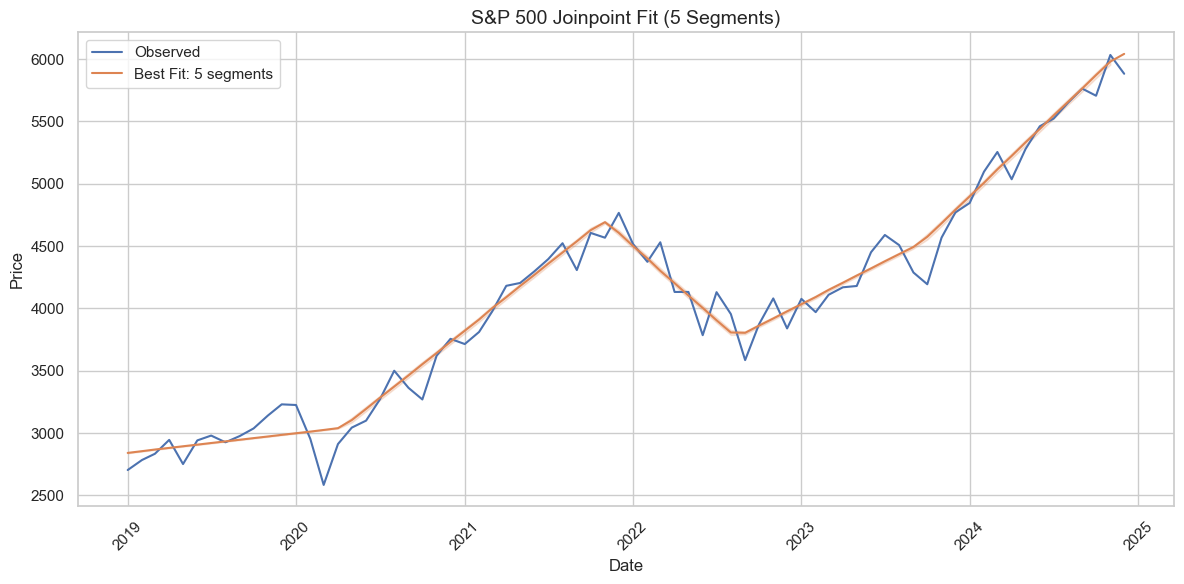


🔍 开始分析: NASDAQ
✅ 完成: NASDAQ（最优段数: 5, AIC: 901.88, 用时: 1.15秒）


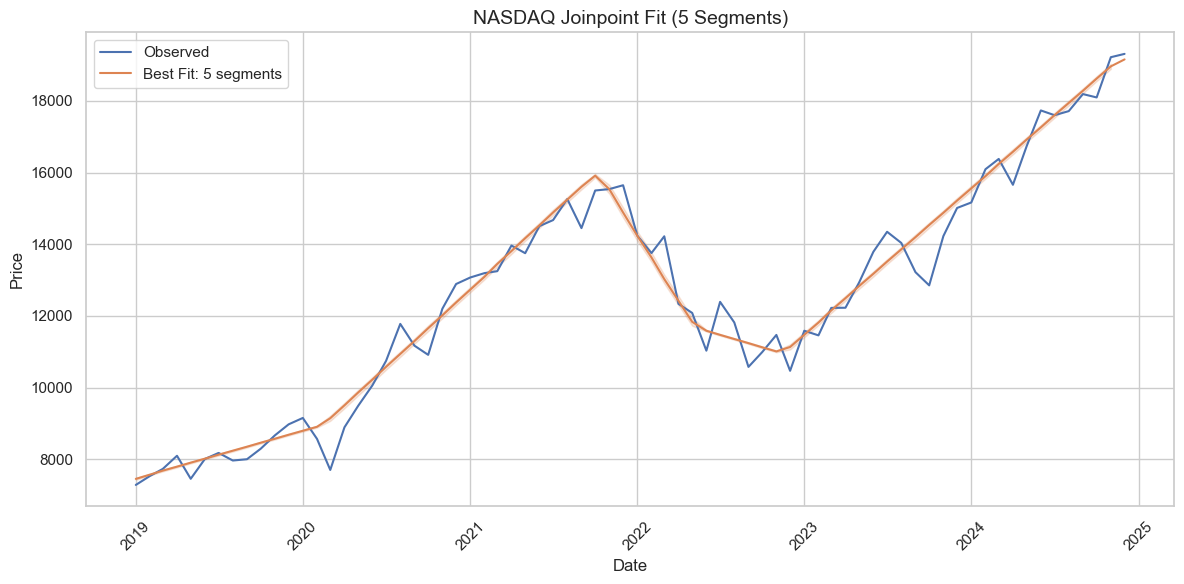


🔍 开始分析: VIX
✅ 完成: VIX（最优段数: 5, AIC: 220.83, 用时: 0.97秒）


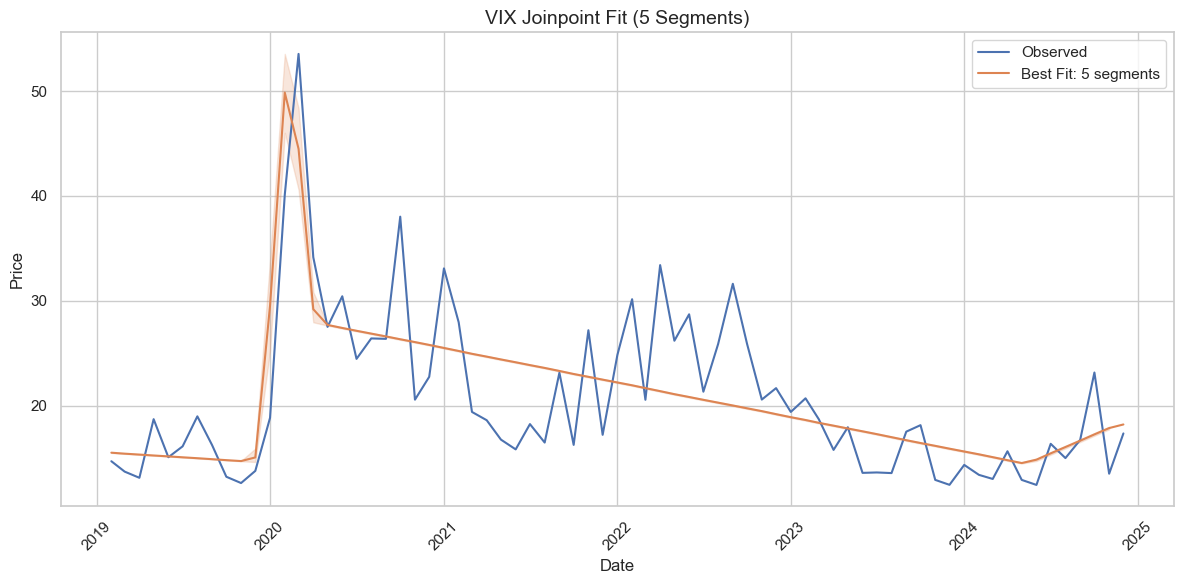

In [41]:
import pandas as pd
import numpy as np
import pwlf
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# 文件路径和名称
file_paths = {
    'S&P 500': 'data/SP500.csv',
    'NASDAQ': 'data/NASDAQ.csv',
    'VIX': 'data/VIX.csv'
}

# 存放所有指标的模型评估结果
results_summary = []

# 设置风格
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

for name, path in file_paths.items():
    print(f"\n🔍 开始分析: {name}")
    start_time = time.time()

    # 读取并处理数据
    df = pd.read_csv(path)
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date')
    df['Price'] = pd.to_numeric(df['Price'].astype(str).str.replace('[\$,]', '', regex=True), errors='coerce')
    df = df[['Date', 'Price']].dropna()

    # 用数字表示时间（x轴）
    df['TimeIndex'] = np.arange(len(df))
    x = df['TimeIndex'].values
    y = df['Price'].values

    best_aic = np.inf
    best_model = None
    best_k = 1
    model_records = []

    # 尝试1至4段线性分段
    for k in range(1, 6):
        model = pwlf.PiecewiseLinFit(x, y)
        try:
            model.fit(k)
            rss = np.sum((y - model.predict(x))**2)
            n = len(x)
            p = k + 1  # 模型参数数目（斜率 + 截距 + breakpoints数量）
            aic = n * np.log(rss / n) + 2 * p
            bic = n * np.log(rss / n) + p * np.log(n)


            model_records.append({
                'Index': name,
                'Segments': k,
                'RSS': rss,
                'AIC': aic,
                'BIC': bic
            })

            if aic < best_aic:
                best_aic = aic
                best_model = model
                best_k = k
        except Exception as e:
            print(f"⚠️  {name} - Segment {k} 失败: {e}")
    
    # 拟合结束，结果收集
    elapsed = time.time() - start_time
    print(f"✅ 完成: {name}（最优段数: {best_k}, AIC: {best_aic:.2f}, 用时: {elapsed:.2f}秒）")
    # 可视化最优模型（使用真实日期）
    plt.figure()

    # 生成拟合曲线数据
    x_hat = np.linspace(x.min(), x.max(), num=500)
    y_hat = best_model.predict(x_hat)

    # 将 x_hat 映射回日期（使用线性插值）
    date_range = pd.date_range(start=df['Date'].iloc[0], periods=len(df), freq='MS')  # 月度起点对齐
    date_interp = pd.Series(date_range).iloc[(x_hat).astype(int).clip(0, len(date_range)-1)].values

    # 绘图
    sns.lineplot(x=df['Date'], y=y, label='Observed')
    sns.lineplot(x=date_interp, y=y_hat, label=f'Best Fit: {best_k} segments')

    plt.title(f'{name} Joinpoint Fit ({best_k} Segments)', fontsize=14)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.legend()
    plt.show()
    # 汇总结果
    results_summary.extend(model_records)

In [40]:
import pandas as pd
import numpy as np
import pwlf
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# 文件路径和名称
file_paths = {
    'S&P 500': 'data/SP500.csv',
    'NASDAQ': 'data/NASDAQ.csv',
    'VIX': 'data/VIX.csv'
}

# 存放所有指标的模型评估结果
results_summary = []

# 设置风格
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

for name, path in file_paths.items():
    print(f"\n🔍 开始分析: {name}")
    start_time = time.time()

    # 读取并处理数据
    df = pd.read_csv(path)
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date')
    df['Price'] = pd.to_numeric(df['Price'].astype(str).str.replace('[\$,]', '', regex=True), errors='coerce')
    df = df[['Date', 'Price']].dropna()

    # 用数字表示时间（x轴）
    df['TimeIndex'] = np.arange(len(df))
    x = df['TimeIndex'].values
    y = df['Price'].values

    best_aic = np.inf
    best_model = None
    best_k = 1
    model_records = []

    # 尝试1至4段线性分段
    for k in range(1, 6):
        model = pwlf.PiecewiseLinFit(x, y)
        try:
            model.fit(k)
            rss = np.sum((y - model.predict(x))**2)
            n = len(x)
            p = k + 1  # 模型参数数目（斜率 + 截距 + breakpoints数量）
            aic = n * np.log(rss / n) + 2 * p
            bic = n * np.log(rss / n) + p * np.log(n)


            model_records.append({
                'Index': name,
                'Segments': k,
                'RSS': rss,
                'AIC': aic,
                'BIC': bic
            })

            if aic < best_aic:
                best_aic = aic
                best_model = model
                best_k = k
        except Exception as e:
            print(f"⚠️  {name} - Segment {k} 失败: {e}")
    
    # 拟合结束，结果收集
    elapsed = time.time() - start_time
    print(f"✅ 完成: {name}（最优段数: {best_k}, AIC: {best_aic:.2f}, 用时: {elapsed:.2f}秒）")

    # 提取分段信息（Joinpoints 和 APC）
    breaks = best_model.fit_breaks
    slopes = best_model.slopes
    slope_stderr = best_model.standard_errors()  # 提取一次标准误
    apc_data = []
    for i in range(len(slopes)):
        idx_start = int(breaks[i])
        idx_end = int(breaks[i + 1]) - 1  # 保证闭区间
        date_start = df.iloc[idx_start]['Date']
        date_end = df.iloc[min(idx_end, len(df)-1)]['Date']
        slope = slopes[i]
        
        # 将每单位TimeIndex（月）变化的斜率转换为年化百分比变化
        # 使用对数近似：APC ≈ (1 + r)^12 - 1 ≈ 12 * r
        apc = (slope / y[idx_start]) * 12 * 100
        # 获取标准误差（来自 pwlf 内部方法）
        slope_stderr = best_model.standard_errors()

        se = slope_stderr[i]

        # t 值和 p 值
        t_stat = slope / se
        from scipy.stats import t
        df_resid = len(x) - (best_k + 1)  # 自由度 ≈ 样本数 - 参数个数
        p_value = 2 * (1 - t.cdf(np.abs(t_stat), df=df_resid))

        # 显著性判断
        significance = 'Yes' if p_value < 0.05 else 'No'

        apc_data.append({
            'Index': name,
            'Segment': i + 1,
            'Start_Date': date_start,
            'End_Date': date_end,
            'Slope': slope,
            'APC (%)': apc,
            't-stat': t_stat,
            'p-value': p_value,
            'Significant (p<0.05)': significance
        })


    # 转换成DataFrame并输出
    apc_df = pd.DataFrame(apc_data)
    print(f"\n📈 {name} 各段趋势变化（APC）：")
    print(apc_df)
    # 汇总结果
    results_summary.extend(model_records)


🔍 开始分析: S&P 500
✅ 完成: S&P 500（最优段数: 5, AIC: 715.78, 用时: 1.17秒）

📈 S&P 500 各段趋势变化（APC）：
     Index  Segment Start_Date   End_Date       Slope    APC (%)     t-stat  \
0  S&P 500        1 2019-01-01 2020-03-01   13.433696   5.961479   0.219846   
1  S&P 500        2 2020-04-01 2021-10-01   90.180358  37.156749  16.319685   
2  S&P 500        3 2021-11-01 2022-07-01  -99.463641 -26.134524 -11.450012   
3  S&P 500        4 2022-08-01 2023-09-01   57.548606  17.461018   5.036036   
4  S&P 500        5 2023-10-01 2024-11-01  108.500156  31.045874   8.063259   

        p-value Significant (p<0.05)  
0  8.266693e-01                   No  
1  0.000000e+00                  Yes  
2  0.000000e+00                  Yes  
3  3.919678e-06                  Yes  
4  2.040057e-11                  Yes  

🔍 开始分析: NASDAQ
✅ 完成: NASDAQ（最优段数: 5, AIC: 901.88, 用时: 0.98秒）

📈 NASDAQ 各段趋势变化（APC）：
    Index  Segment Start_Date   End_Date       Slope    APC (%)     t-stat  \
0  NASDAQ        1 2019-01-01 2020-01-01

In [42]:
metrics_df = pd.DataFrame(results_summary)
segment_5_df = metrics_df[metrics_df['Segments'] == 5].reset_index(drop=True)
print("\n📊 所有指标模型评估指标：")
print(segment_5_df)


📊 所有指标模型评估指标：
     Index  Segments           RSS         AIC         BIC
0  S&P 500         5  1.265966e+06  715.776946  729.436943
1   NASDAQ         5  1.678616e+07  901.876744  915.536740
2      VIX         5  1.344704e+03  220.828704  234.404783


# stage 2



🔍 开始分析: Federal Funds Rate
✅ 完成: Federal Funds Rate（最优段数: 5, AIC: -246.95, 用时: 1.47秒）


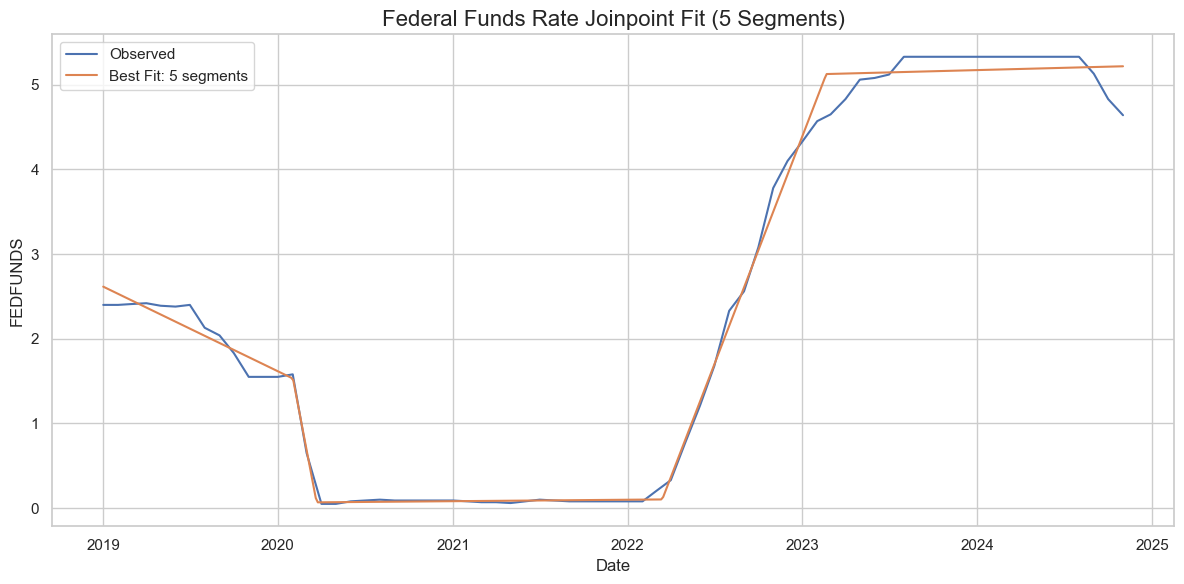


🔍 开始分析: CPI (Consumer Price Index)
✅ 完成: CPI (Consumer Price Index)（最优段数: 5, AIC: -50.54, 用时: 1.13秒）


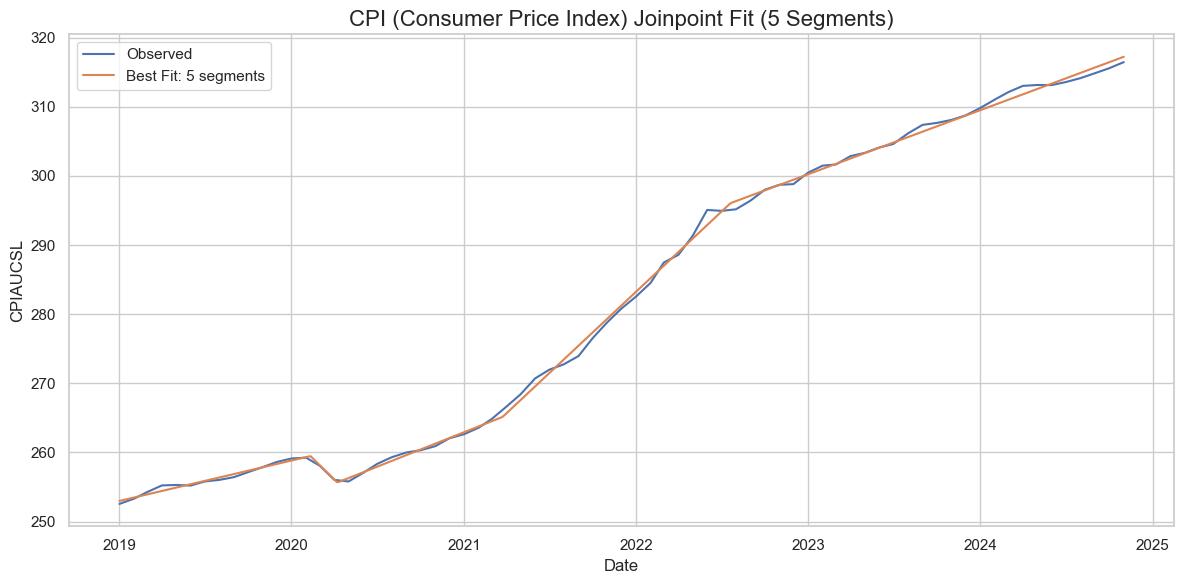


🔍 开始分析: GDP Growth Rate
✅ 完成: GDP Growth Rate（最优段数: 5, AIC: 42.40, 用时: 0.79秒）


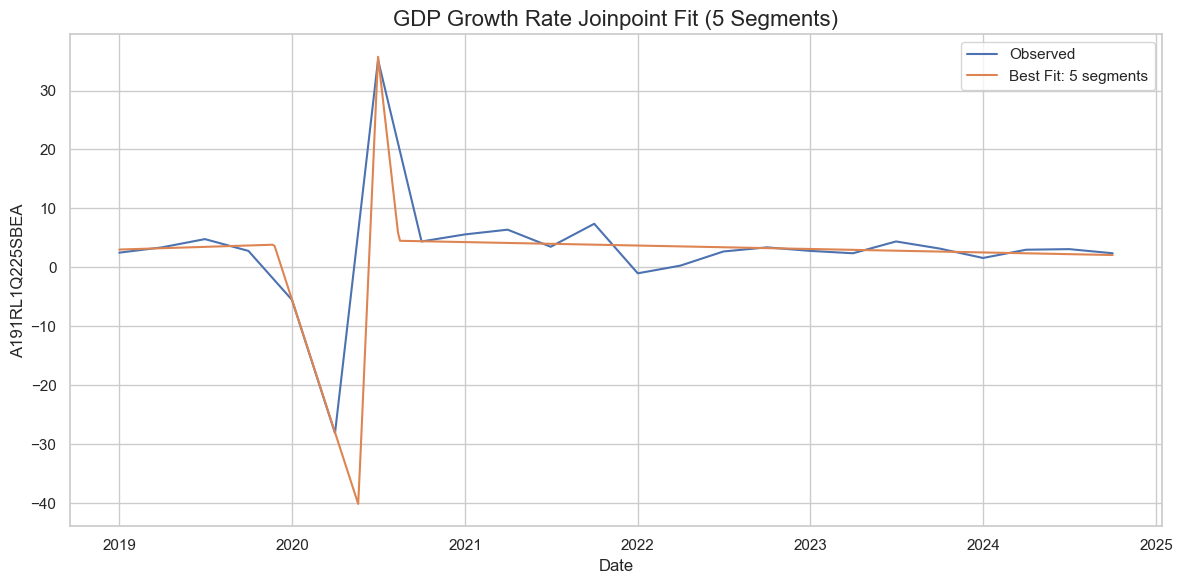


📊 所有宏观指标模型评估指标：
                         Index  Segments          RSS         AIC         BIC
0           Federal Funds Rate         1   165.012054   63.877044   68.402404
1           Federal Funds Rate         2    39.896071  -32.924545  -23.873825
2           Federal Funds Rate         3     9.552240 -130.419196 -116.843117
3           Federal Funds Rate         4     3.627435 -195.164946 -177.063507
4           Federal Funds Rate         5     1.653383 -246.949785 -224.322986
5   CPI (Consumer Price Index)         1  1441.815841  217.779489  222.304849
6   CPI (Consumer Price Index)         2   702.686948  170.748444  179.799164
7   CPI (Consumer Price Index)         3    59.575330   -0.456120   13.119959
8   CPI (Consumer Price Index)         4    46.213844  -14.487434    3.614005
9   CPI (Consumer Price Index)         5    26.290023  -50.537815  -27.911016
10             GDP Growth Rate         1  2147.224955  111.853066  114.209173
11             GDP Growth Rate         2  2111.

In [47]:
import pandas as pd
import numpy as np
import pwlf
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# 设置风格
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# 文件路径与代码匹配名称
macro_paths = {
    'Federal Funds Rate': ('data/FEDFUNDS.csv', 'FEDFUNDS'),
    'CPI (Consumer Price Index)': ('data/CPI.csv', 'CPIAUCSL'),
    'GDP Growth Rate': ('data/GDP.csv', 'A191RL1Q225SBEA'),
}

results_summary = []

for name, (path, value_col) in macro_paths.items():
    print(f"\n🔍 开始分析: {name}")
    start_time = time.time()

    # 加载数据
    df = pd.read_csv(path)
    df['Date'] = pd.to_datetime(df['observation_date'])
    df = df.sort_values('Date')
    df[value_col] = pd.to_numeric(df[value_col], errors='coerce')
    df = df[['Date', value_col]].dropna()

    # 保持与股市时间长度一致
    df = df[(df['Date'] >= '2019-01-01') & (df['Date'] <= '2024-11-01')].reset_index(drop=True)

    # 加入时间索引
    df['TimeIndex'] = np.arange(len(df))
    x = df['TimeIndex'].values
    y = df[value_col].values

    best_aic = np.inf
    best_model = None
    best_k = 1
    model_records = []

    # 尝试不同段数
    for k in range(1, 6):
        model = pwlf.PiecewiseLinFit(x, y)
        try:
            model.fit(k)
            rss = np.sum((y - model.predict(x))**2)
            n = len(x)
            p = 2 * k  # 每段贡献两个参数
            aic = n * np.log(rss / n) + 2 * p
            bic = n * np.log(rss / n) + p * np.log(n)

            model_records.append({
                'Index': name,
                'Segments': k,
                'RSS': rss,
                'AIC': aic,
                'BIC': bic
            })

            if aic < best_aic:
                best_aic = aic
                best_model = model
                best_k = k
        except Exception as e:
            print(f"⚠️  {name} - Segment {k} 失败: {e}")

    # 可视化最优模型
    # 可视化最优模型（使用真实日期作为 x 轴）
    elapsed = time.time() - start_time
    print(f"✅ 完成: {name}（最优段数: {best_k}, AIC: {best_aic:.2f}, 用时: {elapsed:.2f}秒）")
    
    # 为预测线映射真实日期
    x_hat = np.linspace(x.min(), x.max(), num=500)
    y_hat = best_model.predict(x_hat)
    date_interp = pd.date_range(start=df['Date'].min(), end=df['Date'].max(), periods=500)

    plt.figure()
    sns.lineplot(x=df['Date'], y=y, label='Observed')
    sns.lineplot(x=date_interp, y=y_hat, label=f'Best Fit: {best_k} segments')
    plt.title(f'{name} Joinpoint Fit ({best_k} Segments)', fontsize=16)
    plt.xlabel('Date')
    plt.ylabel(value_col)
    plt.legend()
    plt.tight_layout()
    plt.show()


    results_summary.extend(model_records)

# 打印所有模型汇总结果
metrics_df = pd.DataFrame(results_summary)
print("\n📊 所有宏观指标模型评估指标：")
print(metrics_df)


In [48]:
import pandas as pd
import numpy as np
import pwlf
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# 设置风格
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# 文件路径与代码匹配名称
macro_paths = {
    'Federal Funds Rate': ('data/FEDFUNDS.csv', 'FEDFUNDS'),
    'CPI (Consumer Price Index)': ('data/CPI.csv', 'CPIAUCSL'),
    'GDP Growth Rate': ('data/GDP.csv', 'A191RL1Q225SBEA'),
}

results_summary = []

for name, (path, value_col) in macro_paths.items():
    print(f"\n🔍 开始分析: {name}")
    start_time = time.time()

    # 加载数据
    df = pd.read_csv(path)
    df['Date'] = pd.to_datetime(df['observation_date'])
    df = df.sort_values('Date')
    df[value_col] = pd.to_numeric(df[value_col], errors='coerce')
    df = df[['Date', value_col]].dropna()

    # 保持与股市时间长度一致
    df = df[(df['Date'] >= '2019-01-01') & (df['Date'] <= '2024-11-01')].reset_index(drop=True)

    # 加入时间索引
    df['TimeIndex'] = np.arange(len(df))
    x = df['TimeIndex'].values
    y = df[value_col].values

    best_aic = np.inf
    best_model = None
    best_k = 1
    model_records = []

    # 尝试不同段数
    for k in range(1, 6):
        model = pwlf.PiecewiseLinFit(x, y)
        try:
            model.fit(k)
            rss = np.sum((y - model.predict(x))**2)
            n = len(x)
            p = 2 * k  # 每段贡献两个参数
            aic = n * np.log(rss / n) + 2 * p
            bic = n * np.log(rss / n) + p * np.log(n)

            model_records.append({
                'Index': name,
                'Segments': k,
                'RSS': rss,
                'AIC': aic,
                'BIC': bic
            })

            if aic < best_aic:
                best_aic = aic
                best_model = model
                best_k = k
        except Exception as e:
            print(f"⚠️  {name} - Segment {k} 失败: {e}")

    # 可视化最优模型
    # 可视化最优模型（使用真实日期作为 x 轴）
    elapsed = time.time() - start_time
    print(f"✅ 完成: {name}（最优段数: {best_k}, AIC: {best_aic:.2f}, 用时: {elapsed:.2f}秒）")
    # 提取分段信息（Joinpoints 和 APC）
    breaks = best_model.fit_breaks
    slopes = best_model.slopes
    slope_stderr = best_model.standard_errors()  # 提取一次标准误
    apc_data = []
    for i in range(len(slopes)):
        idx_start = int(breaks[i])
        idx_end = int(breaks[i + 1]) - 1  # 保证闭区间
        date_start = df.iloc[idx_start]['Date']
        date_end = df.iloc[min(idx_end, len(df)-1)]['Date']
        slope = slopes[i]
        
        # 将每单位TimeIndex（月）变化的斜率转换为年化百分比变化
        # 使用对数近似：APC ≈ (1 + r)^12 - 1 ≈ 12 * r
        apc = (slope / y[idx_start]) * 12 * 100
        # 获取标准误差（来自 pwlf 内部方法）
        slope_stderr = best_model.standard_errors()

        se = slope_stderr[i]

        # t 值和 p 值
        t_stat = slope / se
        from scipy.stats import t
        df_resid = len(x) - (best_k + 1)  # 自由度 ≈ 样本数 - 参数个数
        p_value = 2 * (1 - t.cdf(np.abs(t_stat), df=df_resid))

        # 显著性判断
        significance = 'Yes' if p_value < 0.05 else 'No'

        apc_data.append({
            'Index': name,
            'Segment': i + 1,
            'Start_Date': date_start,
            'End_Date': date_end,
            'Slope': slope,
            'APC (%)': apc,
            't-stat': t_stat,
            'p-value': p_value,
            'Significant (p<0.05)': significance
        })


    # 转换成DataFrame并输出
    apc_df = pd.DataFrame(apc_data)
    print(f"\n📈 {name} 各段趋势变化（APC）：")
    print(apc_df)
    # 汇总结果
    results_summary.extend(model_records)

# 打印所有模型汇总结果
metrics_df = pd.DataFrame(results_summary)
print("\n📊 所有宏观指标模型评估指标：")
print(metrics_df)



🔍 开始分析: Federal Funds Rate
✅ 完成: Federal Funds Rate（最优段数: 5, AIC: -246.95, 用时: 1.43秒）

📈 Federal Funds Rate 各段趋势变化（APC）：
                Index  Segment Start_Date   End_Date     Slope      APC (%)  \
0  Federal Funds Rate        1 2019-01-01 2020-01-01 -0.083363   -41.681311   
1  Federal Funds Rate        2 2020-02-01 2020-02-01 -1.697996 -1289.617072   
2  Federal Funds Rate        3 2020-03-01 2022-02-01  0.001448     2.672893   
3  Federal Funds Rate        4 2022-03-01 2023-01-01  0.446000  2675.999835   
4  Federal Funds Rate        5 2023-02-01 2024-10-01  0.004506     1.183323   

       t-stat   p-value Significant (p<0.05)  
0   -1.035841  0.304115                   No  
1 -163.283486  0.000000                  Yes  
2    0.010793  0.991422                   No  
3    3.462893  0.000950                  Yes  
4    0.438781  0.662276                   No  

🔍 开始分析: CPI (Consumer Price Index)
✅ 完成: CPI (Consumer Price Index)（最优段数: 5, AIC: -50.54, 用时: 1.08秒）

📈 CPI (Consumer Pr

# stage 3



🔍 开始分析: Technology (XLK)
✅ 完成: Technology (XLK)（最优段数: 4, AIC: 273.06, 用时: 1.24秒）


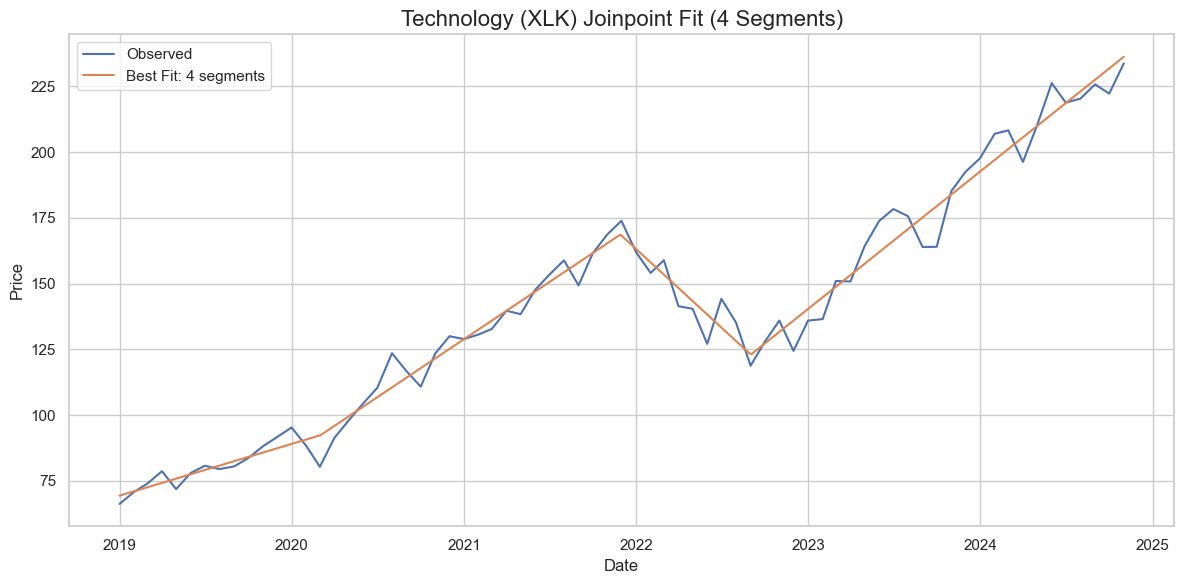


🔍 开始分析: Energy (XLE)
✅ 完成: Energy (XLE)（最优段数: 5, AIC: 220.61, 用时: 1.16秒）


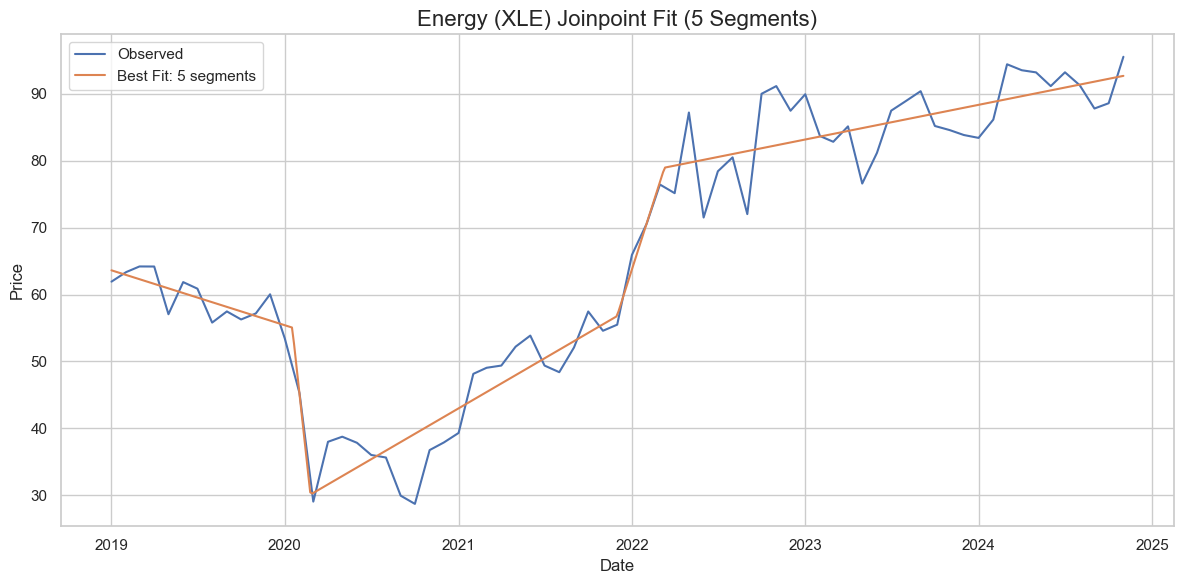


🔍 开始分析: Industrials (XLI)
✅ 完成: Industrials (XLI)（最优段数: 5, AIC: 213.43, 用时: 1.35秒）


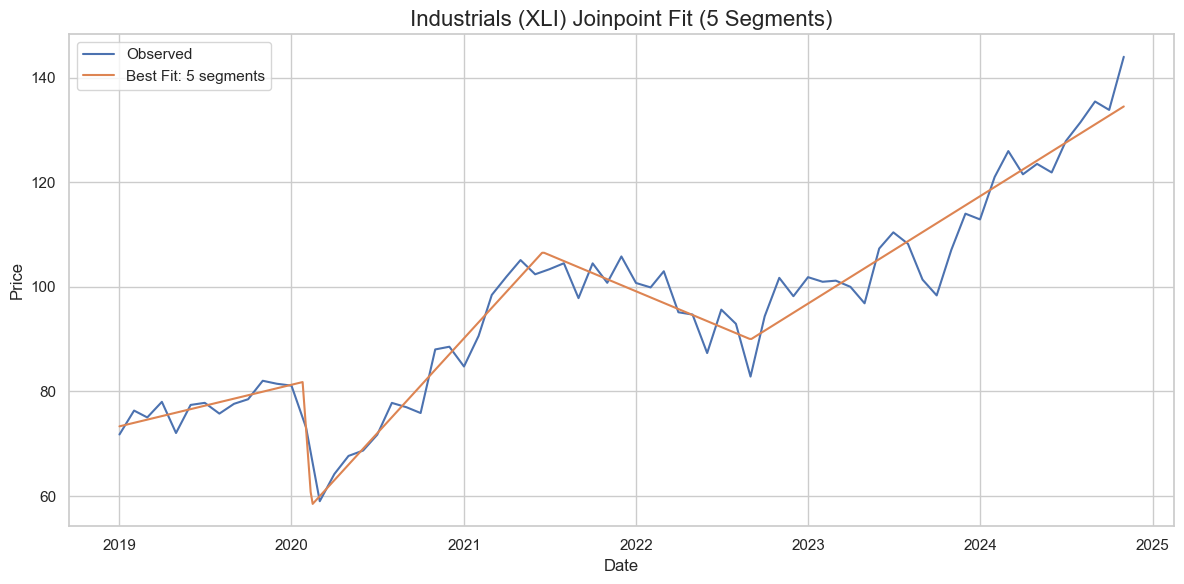


📊 各行业ETF的模型评估指标：
                Index  Segments           RSS         AIC         BIC
0    Technology (XLK)         1  19847.128071  403.952565  408.477925
1    Technology (XLK)         2  15779.935004  391.670836  400.721556
2    Technology (XLK)         3   3565.345515  290.059882  303.635962
3    Technology (XLK)         4   2652.501617  273.061081  291.162520
4    Technology (XLK)         5   2510.403732  273.151848  295.778647
5        Energy (XLE)         1  10723.330430  360.242300  364.767660
6        Energy (XLE)         2   4019.777985  294.577447  303.628167
7        Energy (XLE)         3   1652.946580  235.482078  249.058157
8        Energy (XLE)         4   1497.243077  232.457762  250.559201
9        Energy (XLE)         5   1197.635757  220.605162  243.231960
10  Industrials (XLI)         1   5441.269655  312.075236  316.600596
11  Industrials (XLI)         2   3944.515995  293.235518  302.286237
12  Industrials (XLI)         3   3313.051796  284.849106  298.425186
13

In [49]:
import pandas as pd
import numpy as np
import pwlf
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# 设置风格
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# ETF 文件路径和标签
etf_paths = {
    'Technology (XLK)': 'data/XLK.csv',
    'Energy (XLE)': 'data/XLE.csv',
    'Industrials (XLI)': 'data/XLI.csv'
}

results_summary = []

for name, path in etf_paths.items():
    print(f"\n🔍 开始分析: {name}")
    start_time = time.time()

    # 读取并处理数据
    df = pd.read_csv(path)
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date')
    df['Price'] = pd.to_numeric(df['Price'].astype(str).str.replace('[\$,]', '', regex=True), errors='coerce')
    df = df[['Date', 'Price']].dropna()
    df = df[(df['Date'] >= '2019-01-01') & (df['Date'] <= '2024-11-01')].reset_index(drop=True)

    # 加入时间索引（用于建模）
    df['TimeIndex'] = np.arange(len(df))
    x = df['TimeIndex'].values
    y = df['Price'].values

    best_aic = np.inf
    best_model = None
    best_k = 1
    model_records = []

    for k in range(1, 6):
        model = pwlf.PiecewiseLinFit(x, y)
        try:
            model.fit(k)
            rss = np.sum((y - model.predict(x))**2)
            n = len(x)
            p = 2 * k
            aic = n * np.log(rss / n) + 2 * p
            bic = n * np.log(rss / n) + p * np.log(n)

            model_records.append({
                'Index': name,
                'Segments': k,
                'RSS': rss,
                'AIC': aic,
                'BIC': bic
            })

            if aic < best_aic:
                best_aic = aic
                best_model = model
                best_k = k
        except Exception as e:
            print(f"⚠️  {name} - Segment {k} 失败: {e}")

    elapsed = time.time() - start_time
    print(f"✅ 完成: {name}（最优段数: {best_k}, AIC: {best_aic:.2f}, 用时: {elapsed:.2f}秒）")

    # 可视化（真实时间轴）
    x_hat = np.linspace(x.min(), x.max(), num=500)
    y_hat = best_model.predict(x_hat)
    date_interp = pd.date_range(start=df['Date'].min(), end=df['Date'].max(), periods=500)

    plt.figure()
    sns.lineplot(x=df['Date'], y=y, label='Observed')
    sns.lineplot(x=date_interp, y=y_hat, label=f'Best Fit: {best_k} segments')
    plt.title(f'{name} Joinpoint Fit ({best_k} Segments)', fontsize=16)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.tight_layout()
    plt.show()

    results_summary.extend(model_records)

# 汇总模型指标
metrics_df = pd.DataFrame(results_summary)
print("\n📊 各行业ETF的模型评估指标：")
print(metrics_df)


In [50]:
import pandas as pd
import numpy as np
import pwlf
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# 设置风格
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# ETF 文件路径和标签
etf_paths = {
    'Technology (XLK)': 'data/XLK.csv',
    'Energy (XLE)': 'data/XLE.csv',
    'Industrials (XLI)': 'data/XLI.csv'
}

results_summary = []

for name, path in etf_paths.items():
    print(f"\n🔍 开始分析: {name}")
    start_time = time.time()

    # 读取并处理数据
    df = pd.read_csv(path)
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date')
    df['Price'] = pd.to_numeric(df['Price'].astype(str).str.replace('[\$,]', '', regex=True), errors='coerce')
    df = df[['Date', 'Price']].dropna()
    df = df[(df['Date'] >= '2019-01-01') & (df['Date'] <= '2024-11-01')].reset_index(drop=True)

    # 加入时间索引（用于建模）
    df['TimeIndex'] = np.arange(len(df))
    x = df['TimeIndex'].values
    y = df['Price'].values

    best_aic = np.inf
    best_model = None
    best_k = 1
    model_records = []

    for k in range(1, 6):
        model = pwlf.PiecewiseLinFit(x, y)
        try:
            model.fit(k)
            rss = np.sum((y - model.predict(x))**2)
            n = len(x)
            p = 2 * k
            aic = n * np.log(rss / n) + 2 * p
            bic = n * np.log(rss / n) + p * np.log(n)

            model_records.append({
                'Index': name,
                'Segments': k,
                'RSS': rss,
                'AIC': aic,
                'BIC': bic
            })

            if aic < best_aic:
                best_aic = aic
                best_model = model
                best_k = k
        except Exception as e:
            print(f"⚠️  {name} - Segment {k} 失败: {e}")

    elapsed = time.time() - start_time
    print(f"✅ 完成: {name}（最优段数: {best_k}, AIC: {best_aic:.2f}, 用时: {elapsed:.2f}秒）")
    # 提取分段信息（Joinpoints 和 APC）
    breaks = best_model.fit_breaks
    slopes = best_model.slopes
    slope_stderr = best_model.standard_errors()  # 提取一次标准误
    apc_data = []
    for i in range(len(slopes)):
        idx_start = int(breaks[i])
        idx_end = int(breaks[i + 1]) - 1  # 保证闭区间
        date_start = df.iloc[idx_start]['Date']
        date_end = df.iloc[min(idx_end, len(df)-1)]['Date']
        slope = slopes[i]
        
        # 将每单位TimeIndex（月）变化的斜率转换为年化百分比变化
        # 使用对数近似：APC ≈ (1 + r)^12 - 1 ≈ 12 * r
        apc = (slope / y[idx_start]) * 12 * 100
        # 获取标准误差（来自 pwlf 内部方法）
        slope_stderr = best_model.standard_errors()

        se = slope_stderr[i]

        # t 值和 p 值
        t_stat = slope / se
        from scipy.stats import t
        df_resid = len(x) - (best_k + 1)  # 自由度 ≈ 样本数 - 参数个数
        p_value = 2 * (1 - t.cdf(np.abs(t_stat), df=df_resid))

        # 显著性判断
        significance = 'Yes' if p_value < 0.05 else 'No'

        apc_data.append({
            'Index': name,
            'Segment': i + 1,
            'Start_Date': date_start,
            'End_Date': date_end,
            'Slope': slope,
            'APC (%)': apc,
            't-stat': t_stat,
            'p-value': p_value,
            'Significant (p<0.05)': significance
        })


    # 转换成DataFrame并输出
    apc_df = pd.DataFrame(apc_data)
    print(f"\n📈 {name} 各段趋势变化（APC）：")
    print(apc_df)
    # 汇总结果
    results_summary.extend(model_records)

# 汇总模型指标
metrics_df = pd.DataFrame(results_summary)
print("\n📊 各行业ETF的模型评估指标：")
print(metrics_df)



🔍 开始分析: Technology (XLK)
✅ 完成: Technology (XLK)（最优段数: 4, AIC: 273.06, 用时: 1.32秒）

📈 Technology (XLK) 各段趋势变化（APC）：
              Index  Segment Start_Date   End_Date     Slope    APC (%)  \
0  Technology (XLK)        1 2019-01-01 2020-01-01  1.638877  29.671881   
1  Technology (XLK)        2 2020-02-01 2021-10-01  3.649022  49.551051   
2  Technology (XLK)        3 2021-11-01 2022-08-01 -5.021702 -35.716229   
3  Technology (XLK)        4 2022-09-01 2024-10-01  4.354980  43.997100   

      t-stat       p-value Significant (p<0.05)  
0   0.558143  5.786356e-01                   No  
1  12.482547  0.000000e+00                  Yes  
2 -12.166404  0.000000e+00                  Yes  
3   9.124889  2.611245e-13                  Yes  

🔍 开始分析: Energy (XLE)
✅ 完成: Energy (XLE)（最优段数: 5, AIC: 220.61, 用时: 1.33秒）

📈 Energy (XLE) 各段趋势变化（APC）：
          Index  Segment Start_Date   End_Date      Slope     APC (%)  \
0  Energy (XLE)        1 2019-01-01 2019-12-01  -0.684396  -13.261345   
1  Energy 

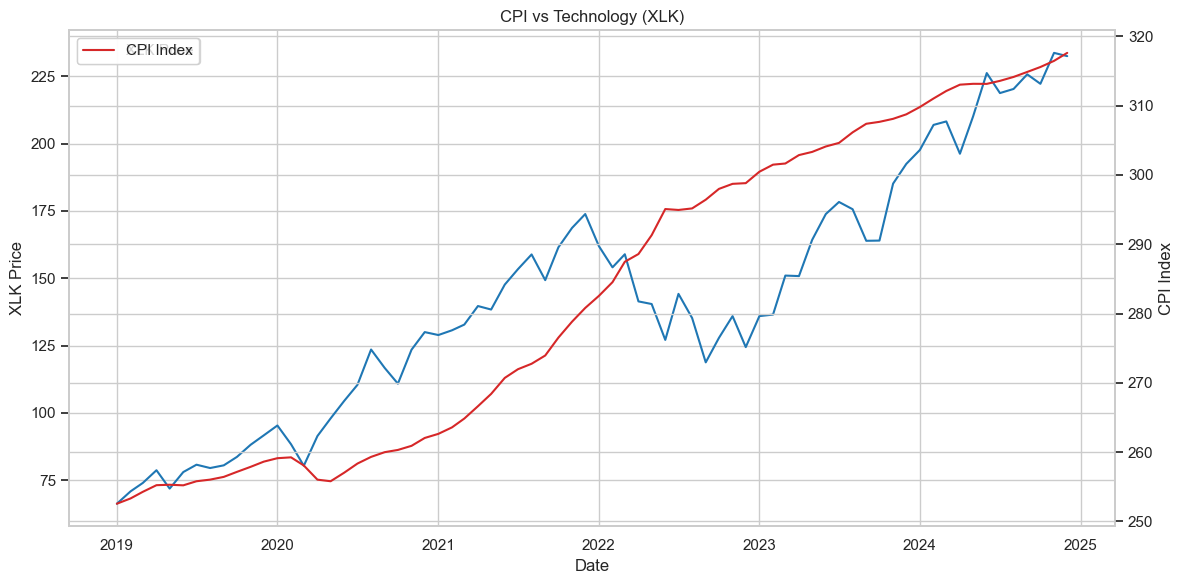

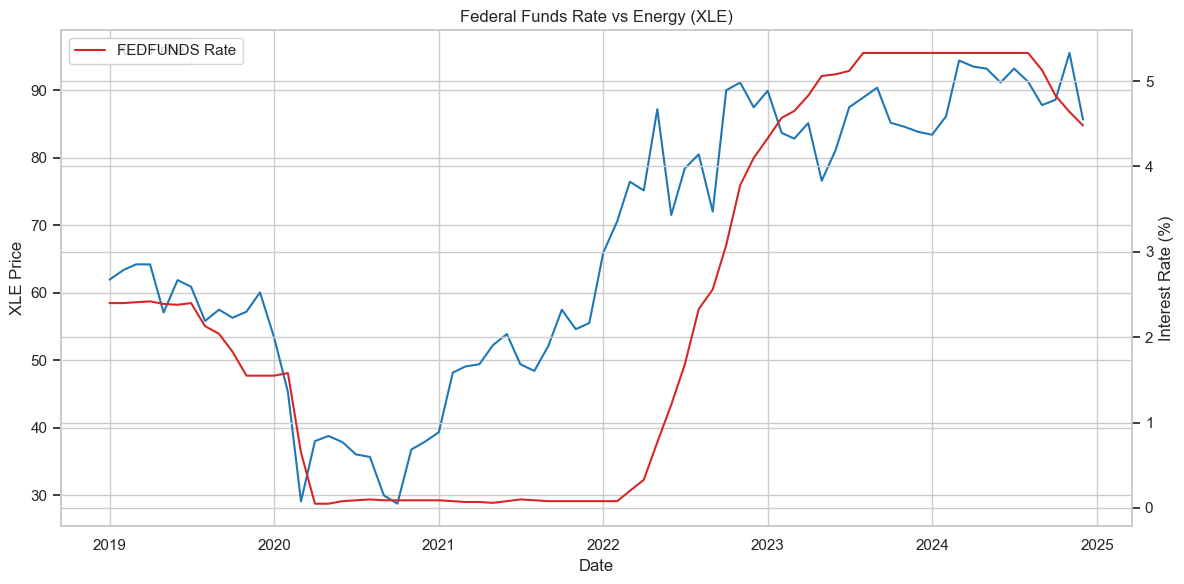

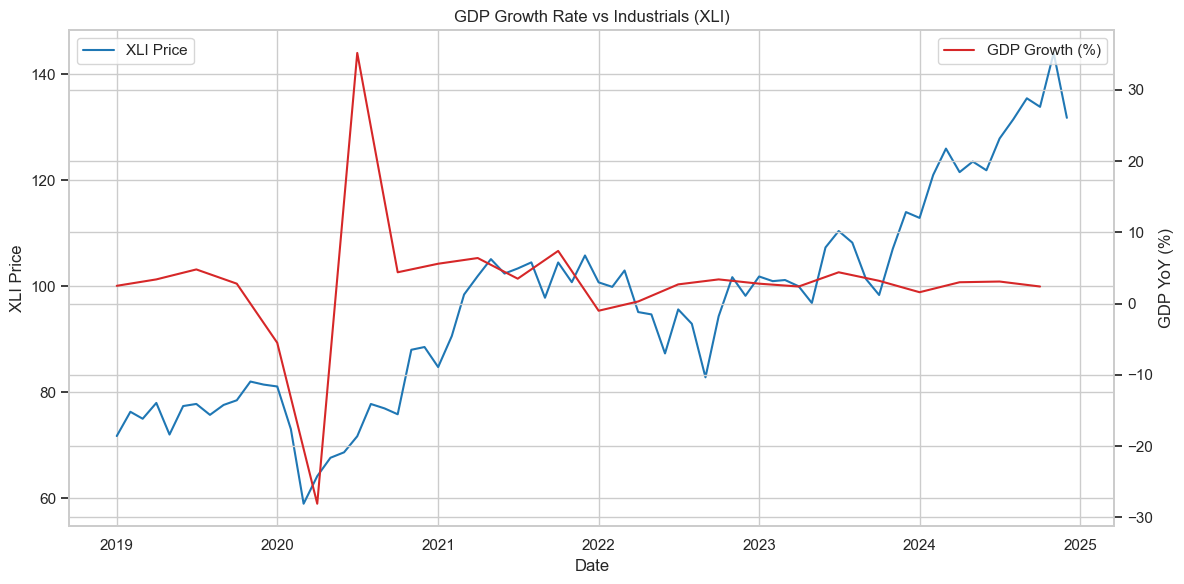

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# 加载数据（路径根据你命名）
df_cpi = pd.read_csv('data/CPI.csv', parse_dates=['observation_date'])
df_fed = pd.read_csv('data/FEDFUNDS.csv', parse_dates=['observation_date'])
df_gdp = pd.read_csv('data/GDP.csv', parse_dates=['observation_date'])

df_xlk = pd.read_csv('data/XLK.csv', parse_dates=['Date'])
df_xle = pd.read_csv('data/XLE.csv', parse_dates=['Date'])
df_xli = pd.read_csv('data/XLI.csv', parse_dates=['Date'])

# CPI vs XLK
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
sns.lineplot(data=df_xlk, x='Date', y='Price', ax=ax1, label='XLK Price', color='tab:blue')
sns.lineplot(data=df_cpi, x='observation_date', y='CPIAUCSL', ax=ax2, label='CPI Index', color='tab:red')
ax1.set_title('CPI vs Technology (XLK)')
ax1.set_ylabel('XLK Price')
ax2.set_ylabel('CPI Index')
fig.tight_layout()
plt.show()

# FEDFUNDS vs XLE
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
sns.lineplot(data=df_xle, x='Date', y='Price', ax=ax1, label='XLE Price', color='tab:blue')
sns.lineplot(data=df_fed, x='observation_date', y='FEDFUNDS', ax=ax2, label='FEDFUNDS Rate', color='tab:red')
ax1.set_title('Federal Funds Rate vs Energy (XLE)')
ax1.set_ylabel('XLE Price')
ax2.set_ylabel('Interest Rate (%)')
fig.tight_layout()
plt.show()

# GDP vs XLI
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
sns.lineplot(data=df_xli, x='Date', y='Price', ax=ax1, label='XLI Price', color='tab:blue')
sns.lineplot(data=df_gdp, x='observation_date', y='A191RL1Q225SBEA', ax=ax2, label='GDP Growth (%)', color='tab:red')
ax1.set_title('GDP Growth Rate vs Industrials (XLI)')
ax1.set_ylabel('XLI Price')
ax2.set_ylabel('GDP YoY (%)')
fig.tight_layout()
plt.show()
